# P15.3 Roads - snowkuma


In [1]:
# Import the required libraries
import pymongo
import datetime
import collections

import pandas as pd
import scipy.stats

import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (15,15) # reset the base size of figures

import folium

In [2]:
# open a connection to the mongo server, the accidents database and name the collections of accidents and labels
client = pymongo.MongoClient('mongodb://localhost:27351/')

db = client.accidents
accidents = db.accidents
labels = db.labels
roads = db.roads

In [3]:
# load theexpanded names of keys and human readable codes into memory

expanded_name = collections.defaultdict(str)
for e in labels.find({'expanded': {"$exists": True}}):
    expanded_name[e['label']] = e['expanded']

label_of = collections.defaultdict(str)
for l in labels.find({'codes': {"$exists": True}}):
    for c in l['codes']:
        try:
            label_of[l['label'], int(c)] = l['codes'][c]
        except ValueError:
            label_of[l['label'], c] = l['codes'][c]

In [51]:
def results_to_table(results, index_name, column_name, results_name,
                     fillna=None,
                     relabel_index=False, relabel_columns=False,
                     index_label=None, column_label=None):

    # Move items in dict of dicts to the top level.
    def flatten(d):
        new_d = {}
        for k in d:
            if isinstance(d[k], dict):
                new_d.update(flatten(d[k]))
            else:
                new_d[k] = d[k]

        return new_d

    df = pd.DataFrame([flatten(r) for r in results])
    df = df.pivot(index=index_name, columns=column_name, values=results_name)

    # optionally, fiddle with names and labels to make the DataFrame pretty.
    if not fillna is None:
        df.fillna(fillna, inplace=True)
    if relabel_columns:
        df.columns = [label_of[column_name, c] for c in df.columns]
    if relabel_index:
        df.index = [label_of[index_name, r] for r in df.index]
    if column_label:
        df.columns.name = column_label
    if index_label:
        df.index.name = index_label
    else:
        df.index.name = index_name
    return df

## Looking at roads
What is in a road document?

In [5]:
roads.find_one()

{'A-Junction': 'LA Boundary',
 'AADFYear': 2012,
 'B-Junction': 'A4086',
 'CP': 506,
 'Fd2WMV': 29.0,
 'FdAll_MV': 2108.0,
 'FdBUS': 17.0,
 'FdCar': 1599.0,
 'FdHGV': 66.0,
 'FdHGVA3': 3.0,
 'FdHGVA5': 10.0,
 'FdHGVA6': 7.0,
 'FdHGVR2': 40.0,
 'FdHGVR3': 2.0,
 'FdHGVR4': 4.0,
 'FdLGV': 397.0,
 'FdPC': 20.0,
 'Latitude': 53.12266010696906,
 'LenNet': 8.4,
 'LenNet_miles': 5.21,
 'Longitude': -4.001657045120545,
 'ONS GOR Name': 'Wales',
 'ONS LA Name': 'Conwy',
 'RCat': 'TR',
 'Road': 'A5',
 'S Ref E': 266150,
 'S Ref N': 360260,
 '_id': ObjectId('533ed2c589f6f9ee18bae9e5'),
 'loc': {'coordinates': [-4.001657045120545, 53.12266010696906],
  'type': 'Point'}}

what do the codes mean?

In [6]:
expanded_name['FdAll_MV']

'All motor vehicles'

In [7]:
expanded_name['FdHGVA6']

'Articulated HGV with six axles'

What are the road categories?

In [8]:
[(c, label_of['RCat', c]) for k, c in label_of if k == 'RCat']

[('PU', 'Urban principal road'),
 ('CU', 'Urban C road'),
 ('TR', 'Rural trunk road'),
 ('TM', 'Trunk motorway'),
 ('UR', 'Rural U road'),
 ('BU', 'Urban B road'),
 ('TU', 'Urban trunk road'),
 ('BR', 'Rural B road'),
 ('PM', 'Principal motorway'),
 ('UU', 'Urban U road'),
 ('CR', 'Rural C road'),
 ('PR', 'Rural principal road')]

Note that not every road segment has a location.  We'll have to bear that in mind when doing geographical analysis of the roads dataset.

In [9]:
roads.find({'loc': {'$exists': False}}).count()

96

In [10]:
roads.find({'loc': {'$exists': True}}).count()

17891

## Plotting some road points
To start with lets just plot some road segments on the map to see where they are. We'll reuse the map-making procedures frome Notebook 15.1

In [11]:
def add_accidents_markers(the_map, query, number_of_sides=5, fill_color='#769d96',
    limit=0, radius=5, rotation=54):
    for a in accidents.find(query, ['loc.coordinates'],limit=limit):
        folium.RegularPolygonMarker(
            location=[a['loc']['coordinates'][1], a['loc']['coordinates'][0]],
            number_of_sides=number_of_sides, radius=radius, rotation=rotation,
            fill_color=fill_color).add_to(the_map)

In [14]:
def add_roads_markers(the_map, query, number_of_sides=5, fill_color='#769d96',
    limit=0, radius=5, rotation=54):
    for r in roads.find(query, ['loc.coordinates'], limit=limit):
        folium.RegularPolygonMarker(
            location=[r['loc']['coordinates'][1], r['loc']['coordinates'][0]],
            number_of_sides=number_of_sides, radius=radius, rotation=rotation,
            fill_color=fill_color).add_to(the_map)

In [15]:
m = folium.Map([55, -3], zoom_start=6)

add_roads_markers(m, {'loc': {'$exists': True}}, limit=1000)
m

observations:  we can see that the road data only covers Britain, but nothing in Ireland

## milton Keynes
Lets zoom in on MK home of the OU.  THe Polygon defines the area we're interested in.'

In [17]:
milton_keynes = {'type': 'Polygon',
                'coordinates': [[[-0.869719, 52.066547],
                                 [-0.651709, 52.066547],
                                 [-0.651709, 51.997161],
                                 [-0.869719, 51.997161],
                                 [-0.869719, 52.066547]
                                ]]}

min_mk_lat = min(p[1] for p in milton_keynes['coordinates'][0])
max_mk_lat = max(p[1] for p in milton_keynes['coordinates'][0])
min_mk_lon = min(p[0] for p in milton_keynes['coordinates'][0])
max_mk_lon = max(p[0] for p in milton_keynes['coordinates'][0])

mk_centre = [min_mk_lat + (max_mk_lat - min_mk_lat)/2, min_mk_lon + (max_mk_lon - min_mk_lon)/2]

mk_region_query = {'loc': {'$geoWithin': {'$geometry': milton_keynes}}}

In [18]:
roads.find(mk_region_query).count()

24

In [19]:
[r for r in roads.find(mk_region_query, {'FdAll_MV':1, 'Road':1, 'RCat':1, 'LenNet':1, '_id':0})]

[{'FdAll_MV': 18805.0, 'LenNet': 4.2, 'RCat': 'PU', 'Road': 'A4146'},
 {'FdAll_MV': 32672.0, 'LenNet': 2.2, 'RCat': 'TU', 'Road': 'A5'},
 {'FdAll_MV': 32141.0, 'LenNet': 1.8, 'RCat': 'TR', 'Road': 'A5'},
 {'FdAll_MV': 17263.0, 'LenNet': 0.7, 'RCat': 'PU', 'Road': 'A421'},
 {'FdAll_MV': 31404.0, 'LenNet': 3.2, 'RCat': 'PU', 'Road': 'A421'},
 {'FdAll_MV': 20217.0, 'LenNet': 3.6, 'RCat': 'PU', 'Road': 'A422'},
 {'FdAll_MV': 42642.0, 'LenNet': 1.9, 'RCat': 'TU', 'Road': 'A5'},
 {'FdAll_MV': 35490.0, 'LenNet': 1.2, 'RCat': 'TR', 'Road': 'A5'},
 {'FdAll_MV': 32366.0, 'LenNet': 4.0, 'RCat': 'TR', 'Road': 'A5'},
 {'FdAll_MV': 29862.0, 'LenNet': 3.0, 'RCat': 'PU', 'Road': 'A422'},
 {'FdAll_MV': 18107.0, 'LenNet': 2.8, 'RCat': 'PU', 'Road': 'A509'},
 {'FdAll_MV': 23224.0, 'LenNet': 2.5, 'RCat': 'PU', 'Road': 'A509'},
 {'FdAll_MV': 37847.0, 'LenNet': 4.3, 'RCat': 'TU', 'Road': 'A5'},
 {'FdAll_MV': 16478.0, 'LenNet': 0.7, 'RCat': 'PR', 'Road': 'A509'},
 {'FdAll_MV': 41262.0, 'LenNet': 0.5, 'RCat':

In [20]:
mk_region_query

{'loc': {'$geoWithin': {'$geometry': {'coordinates': [[[-0.869719, 52.066547],
      [-0.651709, 52.066547],
      [-0.651709, 51.997161],
      [-0.869719, 51.997161],
      [-0.869719, 52.066547]]],
    'type': 'Polygon'}}}}

In [21]:
m = folium.Map(mk_centre, zoom_start=12)
add_accidents_markers(m, mk_region_query, fill_color='#ff0000', number_of_sides=6, radius=4)
add_roads_markers(m, mk_region_query, fill_color='#0000ff', number_of_sides=4, radius=10)
m

This clearly shows that not all the roads have traffic flow data

## Explopring the roads data
looking at some of the numbers associated with the traffic flow data. 

In [22]:
mpl.rcParams['figure.figsize'] = (8, 8)

In [24]:
# How many of each type of road section are there and how long are they?
pipeline = [{'$group': {'_id': '$RCat',
                       'length': {'$avg': '$LenNet'},
                       'count': {'$sum': 1}}}]
results = list(roads.aggregate(pipeline))
results

[{'_id': 'PM', 'count': 38, 'length': 1.0894736842105264},
 {'_id': 'TM', 'count': 1111, 'length': 3.2201800180018},
 {'_id': 'TR', 'count': 1812, 'length': 4.467235099337748},
 {'_id': 'PR', 'count': 6106, 'length': 4.515180150671471},
 {'_id': 'PU', 'count': 8614, 'length': 1.238450197353146},
 {'_id': 'TU', 'count': 306, 'length': 1.3468627450980393}]

In [25]:
# put this information into a dataframe
road_lens_df = pd.DataFrame(results)
road_lens_df.set_index('_id', inplace=True)
road_lens_df.index.name = 'RCat'
road_lens_df['category'] = [label_of['RCat', c] for c in road_lens_df.index]
road_lens_df

,count,length,category
RCat,,,
PM,38,1.089474,Principal motorway
TM,1111,3.220180,Trunk motorway
TR,1812,4.467235,Rural trunk road
PR,6106,4.515180,Rural principal road
PU,8614,1.238450,Urban principal road
TU,306,1.346863,Urban trunk road


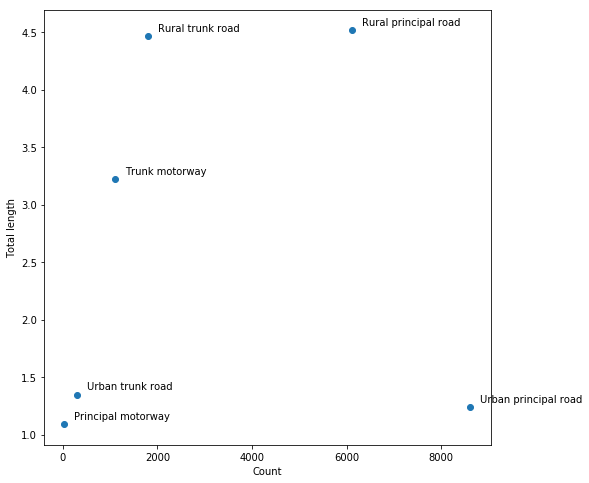

In [26]:
# lets compare road length by category
plt.scatter(road_lens_df['count'], road_lens_df['length'])

plt.xlabel('Count')
plt.ylabel('Total length')
for r in road_lens_df.iterrows():
    plt.annotate(r[1]['category'], xy=(r[1]['count'], r[1]['length']),
                xytext=(10, 5), textcoords='offset points')
plt.show()

unsurprisingly rural road lengths are longer than urban road sections.  There are more principle than trunk road sections , but what are principle motorways

In [29]:
roads.distinct('Road', {'RCat': 'PM'})

['A57M',
 'M65',
 'A64M',
 'M62',
 'A329M',
 'A167M',
 'A601M',
 'M56',
 'M275',
 'A38M',
 'A58M',
 'M55']

In [30]:
# The average lengths shown don't tell us anything about yhe distributon of lengths of different roads

In [31]:
road_lengths_df = pd.DataFrame(list(roads.find({}, ['RCat', 'LenNet'])))
road_lengths_df.describe()

,LenNet
count,17987.000000
mean,2.799994
std,3.816937
min,0.070000
25%,0.600000
50%,1.500000
75%,3.300000
max,55.500000


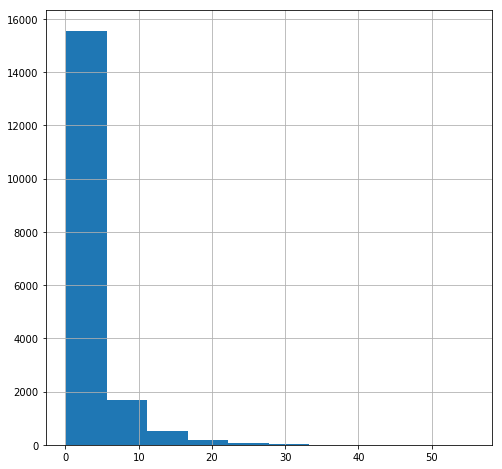

In [32]:
road_lengths_df['LenNet'].hist()

In [33]:
# most road lengths are very short, with a few that are longer.

# is there a difference between rural and urban sections

In [36]:
isUrban = road_lengths_df.apply(lambda r: r['RCat'][1] == 'U', axis=1)
isRural = road_lengths_df.apply(lambda r: r['RCat'][1] == 'R', axis=1)

road_lengths_df[isRural]['LenNet'].describe()


count    7918.000000
mean        4.504208
std         4.949380
min         0.100000
25%         1.100000
50%         2.800000
75%         6.175000
max        55.500000
Name: LenNet, dtype: float64

In [37]:
road_lengths_df[isUrban]['LenNet'].describe()

count    8920.000000
mean        1.242169
std         1.078233
min         0.070000
25%         0.400000
50%         0.900000
75%         1.700000
max        10.600000
Name: LenNet, dtype: float64

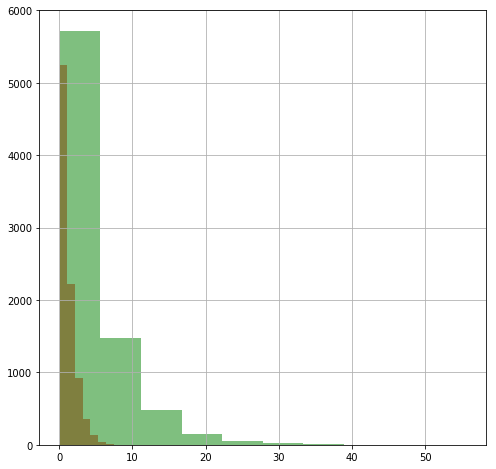

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)

road_lengths_df[isUrban]['LenNet'].hist(ax=ax, alpha=0.5, color='red')
road_lengths_df[isRural]['LenNet'].hist(ax=ax, alpha=0.5, color='green')

## Looking at districts
Which districts have the most roads and the longest roads?

We'll use a pipeline to find the data and plot it on ascatter plot.
'

In [40]:
pipeline = [{'$group': {'_id': '$ONS LA Name',
                       'length': {'$sum': '$LenNet'},
                       'count': {'$sum': 1}}}]
results = list(roads.aggregate(pipeline))
results

[{'_id': 'Isles of Scilly', 'count': 5, 'length': 7.7},
 {'_id': 'Plymouth', 'count': 33, 'length': 42.0},
 {'_id': 'Havering', 'count': 33, 'length': 61.3},
 {'_id': 'Isle of Anglesey', 'count': 42, 'length': 174.1},
 {'_id': 'Newcastle upon Tyne', 'count': 78, 'length': 89.9},
 {'_id': 'Wakefield', 'count': 93, 'length': 203.96},
 {'_id': 'Calderdale', 'count': 65, 'length': 148.0},
 {'_id': 'York', 'count': 54, 'length': 96.32},
 {'_id': 'Conwy', 'count': 61, 'length': 232.9},
 {'_id': 'Trafford', 'count': 43, 'length': 67.9},
 {'_id': 'Lincolnshire', 'count': 201, 'length': 1108.11},
 {'_id': 'Halton', 'count': 43, 'length': 56.05},
 {'_id': 'Liverpool', 'count': 165, 'length': 124.4},
 {'_id': 'Barnsley', 'count': 76, 'length': 167.9},
 {'_id': 'Islington', 'count': 64, 'length': 38.1},
 {'_id': 'Bradford', 'count': 109, 'length': 154.7},
 {'_id': 'Kent', 'count': 466, 'length': 1134.94},
 {'_id': 'Warwickshire', 'count': 225, 'length': 619.0},
 {'_id': 'Cumbria', 'count': 206, 'l

In [41]:
ons_lens_df = pd.DataFrame(results)
ons_lens_df.set_index('_id', inplace=True)
ons_lens_df.index.name = 'LA'
ons_lens_df

,count,length
LA,,
Isles of Scilly,5,7.70
Plymouth,33,42.00
Havering,33,61.30
Isle of Anglesey,42,174.10
Newcastle upon Tyne,78,89.90
Wakefield,93,203.96
Calderdale,65,148.00
York,54,96.32
Conwy,61,232.90


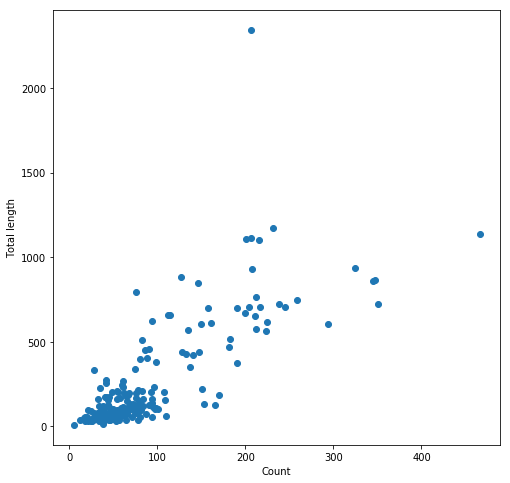

In [42]:
plt.scatter(ons_lens_df['count'], ons_lens_df['length'])
plt.xlabel('Count')
plt.ylabel('Total length')

plt.show()

which are the two outliers?


In [44]:
#  district with the most road sections
ons_lens_df.loc[ons_lens_df['count'].idxmax()]

count      466.00
length    1134.94
Name: Kent, dtype: float64

In [45]:
ons_lens_df.loc[ons_lens_df['length'].idxmax()]

count      206.0
length    2344.8
Name: Highland, dtype: float64

In [46]:
## Activity 1.- HTH we were meant to get this though I'm not sure


In [48]:
# Project, match and group pipeline
pipeline = [
    {'$project': {'ONS LA Name': '$ONS LA Name',
                 'class': {'$substr': ['$RCat', 1, 1]},
                 'LenNet': '$LenNet'}},
    {'$match': {'class': {'$in': ['R', 'U']}}},
    {'$group': {'_id': {'ONS_LA_Name': '$ONS LA Name',
                       'class': '$class'},
               'length': {'$sum': '$LenNet'},
               'count': {'$sum': 1}}}]

results = list(roads.aggregate(pipeline))

In [49]:
results

[{'_id': {'ONS_LA_Name': 'Isles of Scilly', 'class': 'R'},
  'count': 5,
  'length': 7.7},
 {'_id': {'ONS_LA_Name': 'Leicester', 'class': 'R'},
  'count': 1,
  'length': 3.4},
 {'_id': {'ONS_LA_Name': 'Wolverhampton', 'class': 'R'},
  'count': 1,
  'length': 0.3},
 {'_id': {'ONS_LA_Name': 'Harrow', 'class': 'R'}, 'count': 1, 'length': 0.6},
 {'_id': {'ONS_LA_Name': 'East Lothian', 'class': 'U'},
  'count': 7,
  'length': 7.6000000000000005},
 {'_id': {'ONS_LA_Name': 'Reading', 'class': 'R'}, 'count': 1, 'length': 0.3},
 {'_id': {'ONS_LA_Name': 'Plymouth', 'class': 'R'}, 'count': 2, 'length': 4.2},
 {'_id': {'ONS_LA_Name': 'Bournemouth', 'class': 'R'},
  'count': 2,
  'length': 2.2},
 {'_id': {'ONS_LA_Name': 'Birmingham', 'class': 'R'},
  'count': 4,
  'length': 6.1},
 {'_id': {'ONS_LA_Name': 'Cardiff', 'class': 'R'},
  'count': 15,
  'length': 29.7},
 {'_id': {'ONS_LA_Name': 'Argyll & Bute', 'class': 'U'},
  'count': 3,
  'length': 8.0},
 {'_id': {'ONS_LA_Name': 'Stockport', 'class': '

In [55]:
ons_class_df = results_to_table(results, 'ONS_LA_Name', 'class', 'count', fillna=0)
ons_class_df

class,R,U
ONS_LA_Name,,
Aberdeen City,14.0,44.0
Aberdeenshire,119.0,8.0
Angus,40.0,19.0
Argyll & Bute,73.0,3.0
Barking and Dagenham,1.0,26.0
Barnet,10.0,84.0
Barnsley,36.0,34.0
Bath and North East Somerset,33.0,45.0
Bedford,31.0,35.0


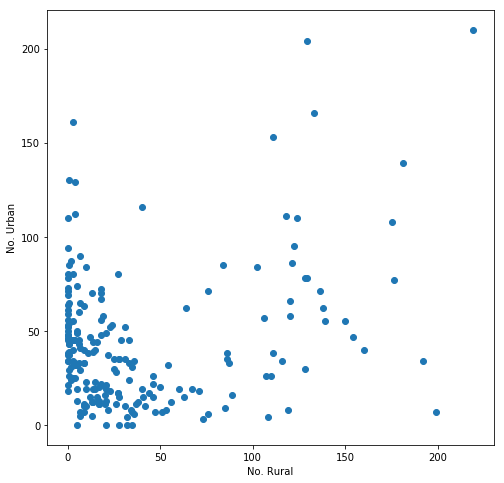

In [56]:
plt.scatter(ons_class_df['R'], ons_class_df['U'])

plt.xlabel('No. Rural')
plt.ylabel('No. Urban')

plt.show()

In [58]:
# which is the district in the top right corner?
ons_class_df.loc[ons_class_df['R'].idxmax()]

class
R    219.0
U    210.0
Name: Kent, dtype: float64

In [60]:
# find the most urban districts
ons_class_df.sort_values('U', ascending=False).head()

class,R,U
ONS_LA_Name,,
Kent,219.0,210.0
Surrey,129.0,204.0
Lancashire,133.0,166.0
Liverpool,3.0,161.0
Hertfordshire,111.0,153.0


In [61]:
# find the most rural districts
ons_class_df.sort_values('R', ascending=False).head()

class,R,U
ONS_LA_Name,,
Kent,219.0,210.0
Highland,199.0,7.0
Devon,192.0,34.0
Staffordshire,181.0,139.0
Derbyshire,176.0,77.0


In [62]:
ons_class_df[(ons_class_df['R'] > 150) | (ons_class_df['U'] > 150)]

class,R,U
ONS_LA_Name,,
Derbyshire,176.0,77.0
Devon,192.0,34.0
Hampshire,175.0,108.0
Hertfordshire,111.0,153.0
Highland,199.0,7.0
Kent,219.0,210.0
Lancashire,133.0,166.0
Lincolnshire,154.0,47.0
Liverpool,3.0,161.0


In [63]:
ons_class_df[(ons_class_df['R'] < 2) | (ons_class_df['U'] < 2)]

class,R,U
ONS_LA_Name,,
Barking and Dagenham,1.0,26.0
Brent,0.0,50.0
Camden,0.0,78.0
City of London,0.0,38.0
Comhairle nan Eilean Siar,28.0,0.0
Croydon,1.0,65.0
Ealing,0.0,48.0
Greenwich,0.0,61.0
Hackney,0.0,56.0


now to look at the road lengths

In [64]:
ons_class_len_df = results_to_table(results, 'ONS_LA_Name', 'class', 'length', fillna=0)
ons_class_len_df

class,R,U
ONS_LA_Name,,
Aberdeen City,28.20,59.60
Aberdeenshire,872.30,12.00
Angus,216.00,26.00
Argyll & Bute,788.90,8.00
Barking and Dagenham,0.40,36.70
Barnet,12.00,84.40
Barnsley,100.60,50.00
Bath and North East Somerset,96.60,36.80
Bedford,85.67,23.60


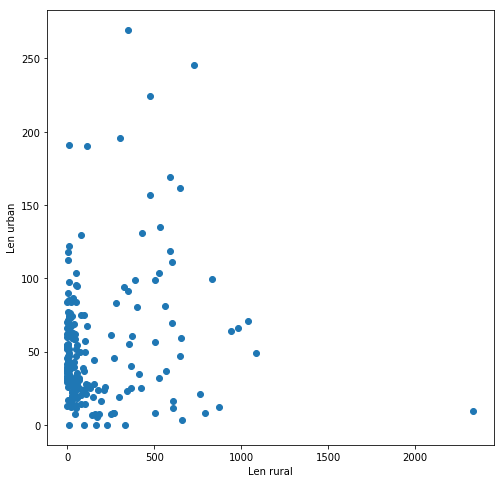

In [65]:
plt.scatter(ons_class_len_df['R'], 
            ons_class_len_df['U']
            )
plt.xlabel('Len rural')
plt.ylabel('Len urban')
plt.show()

most urban and most rural

In [66]:
# most urban
ons_class_len_df.sort_values('U', ascending=False).head()

class,R,U
ONS_LA_Name,,
Surrey,349.72,269.57
Kent,727.64,245.60
Lancashire,476.50,224.30
Hertfordshire,300.40,195.90
Birmingham,6.10,191.10


In [67]:
# most rural 
ons_class_len_df.sort_values('R', ascending=False).head()

class,R,U
ONS_LA_Name,,
Highland,2335.20,9.6
Devon,1082.37,49.4
Lincolnshire,1037.41,70.7
North Yorkshire,982.50,66.2
Cumbria,942.90,64.4


A lot of districts on the left hand edge of the plot can we pick them out?

In [68]:
# using the ratio of urban:rural lenghs, and finding the outliers

In [69]:
ons_class_len_df['UvR'] = ons_class_df['U'] / ons_class_len_df['R']
ons_class_len_df.sort_values('UvR', ascending=False).head(10)

class,R,U,UvR
ONS_LA_Name,,,
Hammersmith and Fulham,0.0,32.09,inf
Hounslow,0.0,70.10,inf
Southwark,0.0,54.00,inf
Camden,0.0,38.00,inf
Lambeth,0.0,54.72,inf
Ealing,0.0,54.20,inf
Sutton,0.0,29.40,inf
Lewisham,0.0,38.00,inf
"Kingston upon Hull, City of",0.0,45.75,inf


How many districts are urban only

In [70]:
ons_class_len_df[ons_class_len_df['R'] == 0].count(), ons_class_len_df.count()

(class
 R      24
 U      24
 UvR    24
 dtype: int64, class
 R      206
 U      206
 UvR    206
 dtype: int64)

In [72]:
24 / 206

0.11650485436893204

### Observations

There are 206 districts. 24 of them (aabout(12%) are entirely urban, with no rural road sections. Five are entirely rural.  The entirely urban districts are in the centers of large cities, with London being dominant here.

Several districts have mant and long sections in both categories. This includes London commuter belt districts (Kent, Surrey, Hertfordshire).

In [73]:
## Activity 2

In [74]:
pipeline = [{'$group': {'_id': '$RCat',
                                 'Fd2WMV': {'$avg': '$Fd2WMV'},
                                 'FdBUS': {'$avg': '$FdBUS'},
                                 'FdCar': {'$avg': '$FdCar'},
                                 'FdHGV': {'$avg': '$FdHGV'},
                                 'FdLGV': {'$avg': '$FdLGV'},
                                 'FdPC': {'$avg': '$FdPC'}}}]

results = list(roads.aggregate(pipeline))
results

[{'Fd2WMV': 277.2894736842105,
  'FdBUS': 404.7631578947368,
  'FdCar': 43802.55263157895,
  'FdHGV': 1886.8684210526317,
  'FdLGV': 6281.4473684210525,
  'FdPC': 0.0,
  '_id': 'PM'},
 {'Fd2WMV': 265.2025202520252,
  'FdBUS': 294.4986498649865,
  'FdCar': 53301.377137713775,
  'FdHGV': 7094.188118811881,
  'FdLGV': 9244.034203420342,
  'FdPC': 0.0,
  '_id': 'TM'},
 {'Fd2WMV': 150.35264900662253,
  'FdBUS': 115.90728476821192,
  'FdCar': 19290.21136865342,
  'FdHGV': 2084.5209713024283,
  'FdLGV': 3408.6451434878586,
  'FdPC': 7.7593818984547465,
  '_id': 'TR'},
 {'Fd2WMV': 93.38257451686866,
  'FdBUS': 81.82181460858172,
  'FdCar': 9232.650507697346,
  'FdHGV': 509.996724533246,
  'FdLGV': 1537.345234195873,
  'FdPC': 25.746315099901736,
  '_id': 'PR'},
 {'Fd2WMV': 256.96772695611793,
  'FdBUS': 374.0855583933132,
  'FdCar': 15437.734966333875,
  'FdHGV': 586.0011609008591,
  'FdLGV': 2360.560947295101,
  'FdPC': 246.19247736243324,
  '_id': 'PU'},
 {'Fd2WMV': 201.62418300653596,
  'Fd

In [75]:
# Put the results in a DataFrame

results_df = pd.DataFrame(results)
results_df.set_index('_id', inplace=True)
results_df.index = [label_of['RCat', r] for r in results_df.index]
results_df.columns = [expanded_name[c] for c in results_df.columns]
results_df

,"Motorcycles, etc.",Busses,Cars,All HGVs,Light vans,Pedal cycles
Principal motorway,277.289474,404.763158,43802.552632,1886.868421,6281.447368,0.000000
Trunk motorway,265.202520,294.498650,53301.377138,7094.188119,9244.034203,0.000000
Rural trunk road,150.352649,115.907285,19290.211369,2084.520971,3408.645143,7.759382
Rural principal road,93.382575,81.821815,9232.650508,509.996725,1537.345234,25.746315
Urban principal road,256.967727,374.085558,15437.734966,586.001161,2360.560947,246.192477
Urban trunk road,201.624183,208.732026,27173.107843,1959.470588,4417.084967,48.885621


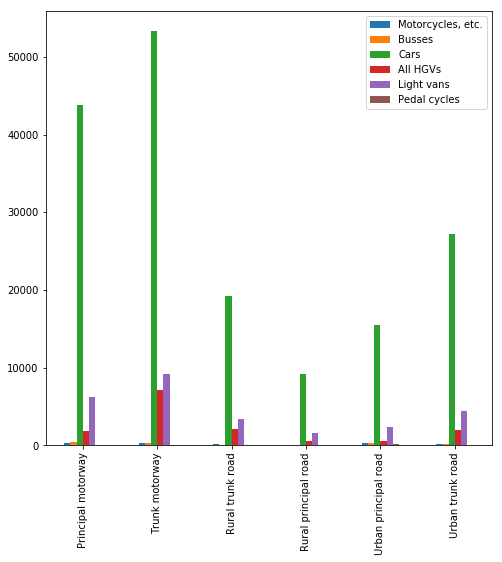

In [76]:
results_df.plot(kind='bar')

To see if the vehicle mixes are different on different roads, we'll have to use a chi-squared test. First, we need to ignore the pedal cycles category, as there are no cyclists on motorways. Then we can find the expected volumes for each vehicle type, assuming no variation between road types.

In [77]:
reduced_results_df = results_df.drop('Pedal cycles', 1)
reduced_results_df.sort_index(axis=0, inplace=True)
reduced_results_df.sort_index(axis=1, inplace=True)
reduced_results_df

,All HGVs,Busses,Cars,Light vans,"Motorcycles, etc."
Principal motorway,1886.868421,404.763158,43802.552632,6281.447368,277.289474
Rural principal road,509.996725,81.821815,9232.650508,1537.345234,93.382575
Rural trunk road,2084.520971,115.907285,19290.211369,3408.645143,150.352649
Trunk motorway,7094.188119,294.498650,53301.377138,9244.034203,265.202520
Urban principal road,586.001161,374.085558,15437.734966,2360.560947,256.967727
Urban trunk road,1959.470588,208.732026,27173.107843,4417.084967,201.624183


In [78]:
# chi square test
chi2, p, _, _ = scipy.stats.chi2_contingency(reduced_results_df)
chi2, p

(3686.1191293657189, 0.0)

Yes, different road types really do have different traffic mixes.